In [1]:
#Import package pandas for data analysis
import pandas as pd
# Import package numpy for numeric computing
import numpy as np
from numpy import int64
from numpy import float64
from numpy import datetime64
# Import package matplotlib for visualisation/plotting
import matplotlib.pyplot as plt
import matplotlib.dates as dates
# Allows plots to appear directly in the notebook.
%matplotlib inline
# For dealing with some Accented characters (in Irish Place names)
import unidecode
# Date/time functionality
import datetime
import time
#for trigonometic calculations
import math
# Check if files exist
from os.path import exists
from os import makedirs
# System specific parameters and functions
import sys
# look at some z-scores for inspecting outliers.
from scipy import stats
import seaborn as sns
# lookup lat/long and convert lat/long to national grid references.
#import geopy
#import pyproj

from patsy import dmatrices
from sklearn import metrics
#binary encoding by using the OneHotEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_graphviz
#from sklearn.tree import export_text

from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso

#import graphviz
#from graphviz import Source
#to read all CSV files in a folder
import os
import glob
import pickle

In [2]:
#method to read chunks from a file and create a dataframe list.
def get_chunks(x):
    """x=[location, dtypes, datecolumns ,date_parser_func, cols]
    exp:mydateparser = lambda x: pd.to_datetime(x, format="%Y-%m-%d %H:%M:%S")
    exp:dtypes={'TRIPID' :'category','PROGRNUMBER':'int16','STOPPOINTID':'category','PLANNEDTIME_ARR':'int64','PLANNEDTIME_DEP':'int64','ACTUALTIME_ARR':'int64','ACTUALTIME_DEP':'int64','DIFFERENCETIME_ARR':'int64','DIFFERENCETIME_DEP':'int64','LINEID':'category','ROUTEID':'category','DIRECTION':'category','TRIPS_TIME_PROPORTION':'float32','TOTAL_JOURNEY_TIME':'int16','TIME_OF_DAY':'category','DAY_OF_WEEK':'category'}
    exp:cols=['Date time','Temperature','Wind Speed','Precipitation','Cloud Cover']
    exp:x=['/Chunks/DBUS/QP_Implementation',dtypes,['ACTUALTIME_ARR_DATETIME'],mydateparser, cols]"""
    path = x[0]
    chunk_folder = glob.glob(os.path.join(path, "*.csv"))
    chunk_list=[]
    counter=0
    for filename in chunk_folder:
        df_chunk = pd.read_csv(filename, low_memory=False, dtype=x[1])
        chunk_list.append(df_chunk)
        print('Index at chunk_list',counter,' is ', filename, ': ',df_chunk.shape)
        counter+=1
    return chunk_list
#chunk_dbus_list=get_chunks(arg_list)

In [3]:
def printMetrics(actualVal, predictions):
    #classification evaluation measures
    print('\n==============================================================================')
    print("MAE: ", metrics.mean_absolute_error(actualVal, predictions))
    print("MSE: ", metrics.mean_squared_error(actualVal, predictions))
    print("RMSE: ", metrics.mean_squared_error(actualVal, predictions)**0.5)
    print("R²: ", metrics.r2_score(actualVal, predictions))

In [4]:
def get_sourcefeatures(file, ROUTEID):
        df = pd.read_csv(file, low_memory=False)
        targetrow_df= df[df.ROUTEID == ROUTEID ]
        features_list=[]
        for column in targetrow_df.columns.values:
            if targetrow_df.iloc[0][column]==1:
                features_list.append(column)
        features_list.remove('TOTAL_JOURNEY_TIME')
        return features_list

In [5]:
def selectFeaturesToCSV(dfs):
    """Adds the selected features into the dictionary to be used to create DataFrame for all routes."""


    def selectFeatures(df):
        """Uses Pearson correlation to select features with at least 0.05 score.
        
        Selected features returned as a list."""
        cor = df.corr()


        def correctSinCos(features_series):
            '''Checks presence of sin/cos pair in relevant features.

            Adds other if only one is found. Adds both if none are found.'''

            features = list(features_series.keys())

            cos = 'cos_hour_of_day'
            sin = 'sin_hour_of_day'

            if (sin in features) & (cos in features):
                pass

            elif (sin not in features) & (cos not in features):
                features.append(sin)
                features.append(cos)

            elif (sin in features) & (cos not in features):
                features.append(cos)

            else:
                features.append(sin)

            return features

        #Correlation with output variable
        cor_target = abs(cor["TOTAL_JOURNEY_TIME"])
        #Selecting highly correlated features
        relevant_features = cor_target[cor_target>0.05]


        selected_features = correctSinCos(relevant_features)
        return selected_features

    # create an empty dataframe to build selected features
    col_names = list(dfs[0].keys())

    df_dict = {}

    for col in col_names:
        df_dict[f'{col}'] = []
    
    for df in dfs:
        selected = selectFeatures(df)

        routeid = df['ROUTEID'].unique()[0]

        for col in col_names:
            if col == 'ROUTEID':
                df_dict['ROUTEID'].append(routeid)
            elif col in selected and col != 'ROUTEID':
                df_dict[f'{col}'].append(1)
            elif col not in selected and col != 'ROUTEID':
                df_dict[f'{col}'].append(0)
                
    features_df = pd.DataFrame(df_dict)
    features_df.to_csv('Feature_selection_V1.csv', index=False)
        

In [23]:
def getPickle(model, modelname, df, features_file):
    """File to generate complete pickel file for a dataframe.
    
    Selects features based on feature selection recommendation in table"""
    
    def get_sourcefeatures(file, ROUTEID):
        df = pd.read_csv(file, low_memory=False)
        targetrow_df= df[df.ROUTEID == ROUTEID ]
        features_list=[]
        for column in targetrow_df.columns.values:
            if targetrow_df.iloc[0][column]==1:
                features_list.append(column)
        features_list.remove('TOTAL_JOURNEY_TIME')
        return features_list
    
    global mae_all
    global mse_all
    global rmse_all
    global r2_all
    global CV_mae_all
    global CV_rmse_all
    global CV_r2_all
    global results_df
    
    # shuffle
    df = df.sample(frac=1)
    source_features = get_sourcefeatures(f'{features_file}', df['ROUTEID'].unique()[0])
    y=df['TOTAL_JOURNEY_TIME']
    X=df[source_features]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

    model = model.fit(X_train, y_train)
    prediction = model.predict(X_test)
    
    mae = metrics.mean_absolute_error(y_test, prediction)
    mse = metrics.mean_squared_error(y_test, prediction)
    rmse = metrics.mean_squared_error(y_test, prediction)**0.5
    r2 = metrics.r2_score(y_test, prediction)
    
    mae_all.append(mae)
    mse_all.append(mse)
    rmse_all.append(rmse)
    r2_all.append(r2)
    
    # 3-fold CV
    
    accuracyR2 = cross_val_score(model, X, y, scoring='r2', cv = 3)
    CV_r2_all.append(accuracyR2.mean())
    
    accuracyMAE = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv = 3)
    CV_mae_all.append(accuracyMAE.mean())
    
    accuracyRMSE = cross_val_score(model, X, y, scoring='neg_root_mean_squared_error', cv = 3)
    CV_rmse_all.append(accuracyRMSE.mean())
    
    # generate pickle file
    routeid = df['ROUTEID'].unique()[0]
    filename = routeid+'.pkl'
    with open(f'pickle_files/{filename}', 'wb') as handle:
        pickle.dump(model, handle, pickle.HIGHEST_PROTOCOL)
        
    # create a dataframe of the results
    data = [[modelname, routeid, accuracyMAE.mean(), accuracyRMSE.mean(), accuracyR2.mean()]]
    row_df = pd.DataFrame(data, columns=['MODEL','ROUTEID','MAE', 'RMSE','R2'])
    results_df = pd.concat([results_df,row_df],axis=0,ignore_index=True)
    
    return results_df
    

In [27]:
# set out criteria for loading in chunks
dtype={'PLANNEDTIME_DEP':'int64',
       'ROUTEID':'category',
       'TOTAL_JOURNEY_TIME':'int16',
       'rain':'float16',
       'temp':'float16',
       'wet_bulb_temp(C)':'float16',
       'dew_pt_temp(C)':'float16',
       'vapour_pressure(hPa)':'float16',
       'humidity(%)':'int16',
       'sea_lvl_pressure(hPa)':'float16',
       'sin_hour_of_day': 'float32',
       'cos_hour_of_day': 'float32',
       'friday':'int16',
       'monday':'int16',
       'saturday':'int16',
       'sunday':'int16',
       'thursday':'int16',
       'tuesday':'int16',
       'wednesday':'int16'}


data_list = ["../../Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/", dtype]

# apply function
chunks = get_chunks(data_list)

Index at chunk_list 0  is  ../../Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/18_3.csv :  (3896, 19)
Index at chunk_list 1  is  ../../Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/67_6.csv :  (4001, 19)
Index at chunk_list 2  is  ../../Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/142_9.csv :  (252, 17)
Index at chunk_list 3  is  ../../Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/17_16.csv :  (307, 16)
Index at chunk_list 4  is  ../../Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/46A_74.csv :  (11186, 19)
Index at chunk_list 5  is  ../../Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/122_14.csv :  (4164, 19)
Index at chunk_list 6  is  ../../Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/150_8.csv :  (4907, 19)
Index at chunk_list 7  is  ../../Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/33X_49.csv :  (181, 17)
Index at chunk_list 8  is  ../../Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/83_19.csv :  (1051, 16)
Index at chunk_list 9  is  ../../Pelin/Chunks/D

Index at chunk_list 79  is  ../../Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/14_16.csv :  (5208, 19)
Index at chunk_list 80  is  ../../Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/15A_83.csv :  (5097, 19)
Index at chunk_list 81  is  ../../Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/39_21.csv :  (4147, 19)
Index at chunk_list 82  is  ../../Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/151_18.csv :  (831, 19)
Index at chunk_list 83  is  ../../Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/238_15.csv :  (1521, 19)
Index at chunk_list 84  is  ../../Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/79A_27.csv :  (2485, 19)
Index at chunk_list 85  is  ../../Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/7_73.csv :  (781, 19)
Index at chunk_list 86  is  ../../Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/69_47.csv :  (592, 18)
Index at chunk_list 87  is  ../../Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/13_66.csv :  (469, 19)
Index at chunk_list 88  is  ../../Peli

Index at chunk_list 167  is  ../../Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/25A_270.csv :  (4648, 19)
Index at chunk_list 168  is  ../../Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/32_57.csv :  (2165, 19)
Index at chunk_list 169  is  ../../Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/41B_53.csv :  (391, 19)
Index at chunk_list 170  is  ../../Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/53_23.csv :  (172, 18)
Index at chunk_list 171  is  ../../Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/44_36.csv :  (1845, 19)
Index at chunk_list 172  is  ../../Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/61_106.csv :  (1760, 19)
Index at chunk_list 173  is  ../../Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/41C_78.csv :  (4171, 19)
Index at chunk_list 174  is  ../../Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/65B_66.csv :  (1992, 19)
Index at chunk_list 175  is  ../../Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/49_27.csv :  (3171, 19)
Index at chunk_list 176 

Index at chunk_list 246  is  ../../Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/17A_18.csv :  (224, 18)
Index at chunk_list 247  is  ../../Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/13_63.csv :  (291, 17)
Index at chunk_list 248  is  ../../Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/66B_59.csv :  (846, 18)
Index at chunk_list 249  is  ../../Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/37_15.csv :  (4984, 19)
Index at chunk_list 250  is  ../../Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/145_105.csv :  (8051, 19)
Index at chunk_list 251  is  ../../Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/16_24.csv :  (7436, 19)
Index at chunk_list 252  is  ../../Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/17A_16.csv :  (234, 18)
Index at chunk_list 253  is  ../../Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/33_72.csv :  (870, 19)
Index at chunk_list 254  is  ../../Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/38A_33.csv :  (173, 17)
Index at chunk_list 255  is 

# Test SVReg on route 18_3

In [28]:
df = chunks[1].copy()
#df.drop('ROUTEID', inplace=True, axis=1)

In [29]:
df

,PLANNEDTIME_DEP,ROUTEID,TOTAL_JOURNEY_TIME,rain,temp,wet_bulb_temp(C),dew_pt_temp(C),vapour_pressure(hPa),humidity(%),sea_lvl_pressure(hPa),sin_hour_of_day,cos_hour_of_day,friday,monday,saturday,sunday,thursday,tuesday,wednesday
0,33062,67_6,3646,0.0,4.500000,3.500000,1.900391,7.000000,83,992.5,0.7070,-0.7070,0,1,0,0,0,0,0
1,34862,67_6,2959,0.0,5.601562,4.300781,2.300781,7.199219,79,993.0,0.7070,-0.7070,0,1,0,0,0,0,0
2,36662,67_6,2636,0.0,5.601562,4.300781,2.300781,7.199219,79,993.0,0.5000,-0.8660,0,1,0,0,0,0,0
3,38888,67_6,3304,0.0,6.699219,5.199219,3.000000,7.601562,77,994.0,0.5000,-0.8660,0,1,0,0,0,0,0
4,40688,67_6,3149,0.0,6.699219,5.199219,3.000000,7.601562,77,994.0,0.2588,-0.9660,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3996,57364,67_6,4331,0.0,9.796875,7.898438,5.601562,9.101562,74,1034.0,-0.8660,-0.5000,0,1,0,0,0,0,0
3997,60964,67_6,4596,0.0,9.796875,7.800781,5.398438,9.000000,74,1035.0,-0.9660,-0.2588,0,1,0,0,0,0,0
3998,68164,67_6,4152,0.0,9.898438,7.898438,5.500000,9.000000,74,1035.0,-0.9660,0.2588,0,1,0,0,0,0,0
3999,71505,67_6,3924,0.0,9.898438,8.000000,5.800781,9.203125,75,1035.0,-0.8660,0.5000,0,1,0,0,0,0,0


## Value scaling and t-t-split

In [30]:
# scale for SVReg
scale = StandardScaler()
df_sc = scale.fit_transform(df)
df_sc = pd.DataFrame(df_sc, columns=df.columns)
df_sc.head()

,PLANNEDTIME_DEP,ROUTEID,TOTAL_JOURNEY_TIME,rain,temp,wet_bulb_temp(C),dew_pt_temp(C),vapour_pressure(hPa),humidity(%),sea_lvl_pressure(hPa),sin_hour_of_day,cos_hour_of_day,friday,monday,saturday,sunday,thursday,tuesday,wednesday
0,-1.352876,0.0,-0.694190,-0.206672,-1.156329,-1.148287,-0.939887,-0.946268,0.619665,-1.761121,1.588084,-0.736122,-0.371404,3.351936,-0.70049,-0.583796,-0.299327,-0.269544,-0.260907
1,-1.251881,0.0,-1.430575,-0.206672,-0.962616,-0.974230,-0.853851,-0.882598,0.353791,-1.718270,1.588084,-0.736122,-0.371404,3.351936,-0.70049,-0.583796,-0.299327,-0.269544,-0.260907
2,-1.150886,0.0,-1.776794,-0.206672,-0.962616,-0.974230,-0.853851,-0.882598,0.353791,-1.718270,1.260059,-0.966895,-0.371404,3.351936,-0.70049,-0.583796,-0.299327,-0.269544,-0.260907
3,-1.025988,0.0,-1.060775,-0.206672,-0.769590,-0.778948,-0.703602,-0.754010,0.220853,-1.632567,1.260059,-0.966895,-0.371404,3.351936,-0.70049,-0.583796,-0.299327,-0.269544,-0.260907
4,-0.924993,0.0,-1.226917,-0.206672,-0.769590,-0.778948,-0.703602,-0.754010,0.220853,-1.632567,0.877839,-1.112035,-0.371404,3.351936,-0.70049,-0.583796,-0.299327,-0.269544,-0.260907


In [31]:
# shuffle and split
df_sc = df.sample(frac=1)
y=df_sc['TOTAL_JOURNEY_TIME']
X=df_sc.drop('TOTAL_JOURNEY_TIME', axis=1)

# filter only correlated features
routeid = df['ROUTEID'].unique()[0]
source_features = get_sourcefeatures('Feature_selection_V1.csv', routeid)
X = X[source_features]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

SVReg = SVR(kernel='poly', C=5)

## Evaluate on training set

In [32]:
# generate model
SVReg.fit(X_train, y_train)

# predict training set
SVReg_prediction = SVReg.predict(X_train)
predictions = pd.DataFrame({ 'actual':y_train,'predicted':SVReg_prediction})
predictions.head()

,actual,predicted
1067,2777,3907.654481
2492,3081,3681.743635
1740,4636,4385.726585
2891,4059,4254.728169
771,5685,4249.806274


## Evaluate on test set

In [33]:
# predict training set
SVReg_prediction = SVReg.predict(X_test)
predictions = pd.DataFrame({ 'actual':y_test,'predicted':SVReg_prediction})
predictions.head()

,actual,predicted
1414,5275,4423.340081
2306,4286,4409.480653
2997,3891,4018.785824
1767,5700,4439.734651
643,4499,4418.764133


In [34]:
print('Metrics on test set after normalising values:')
printMetrics(y_test, SVReg_prediction)

Metrics on test set after normalising values:

MAE:  662.2215696918742
MSE:  791476.4475628033
RMSE:  889.6496206725451
R²:  0.1049618676418611


/home/team8/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


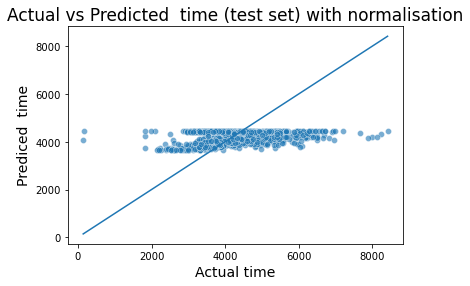

In [35]:
sns.scatterplot(x=y_test, y=SVReg_prediction, alpha=0.6)
sns.lineplot(y_test, y_test)

plt.xlabel('Actual time', fontsize=14)
plt.ylabel('Prediced  time', fontsize=14)
plt.title('Actual vs Predicted  time (test set) with normalisation', fontsize=17)
plt.show()

# SVReg without scaling

In [15]:
# shuffle and split
df = df.sample(frac=1)
y=df['TOTAL_JOURNEY_TIME']
X=df.drop('TOTAL_JOURNEY_TIME', axis=1)

# filter only correlated features
routeid = df['ROUTEID'].unique()[0]
source_features = get_sourcefeatures('Feature_selection_V1.csv', routeid)
X = X[source_features]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)


## Evaluate on training set

In [16]:
# generate model
SVReg.fit(X_train, y_train)

# predict training set
SVReg_prediction = SVReg.predict(X_train)
predictions = pd.DataFrame({ 'actual':y_train,'predicted':SVReg_prediction})
predictions.head()

,actual,predicted
1369,2162,3249.840651
3352,4111,4359.408104
3049,4334,4615.006748
3117,3919,3721.094074
3840,2911,4659.274695


## Evaluate on test set

In [17]:
# predict training set
SVReg_prediction = SVReg.predict(X_test)
predictions = pd.DataFrame({ 'actual':y_test,'predicted':SVReg_prediction})
predictions.head()

,actual,predicted
1011,3190,4695.701434
3575,4652,4581.539106
2908,5931,4154.093117
1155,4167,4337.797472
1192,4652,3404.065270


In [18]:
print('Metrics on test set without normalising values:')
printMetrics(y_test, SVReg_prediction)

Metrics on test set without normalising values:

MAE:  631.2586284765629
MSE:  726378.6726524368
RMSE:  852.2785182394525
R²:  0.15681888945940992


/home/team8/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


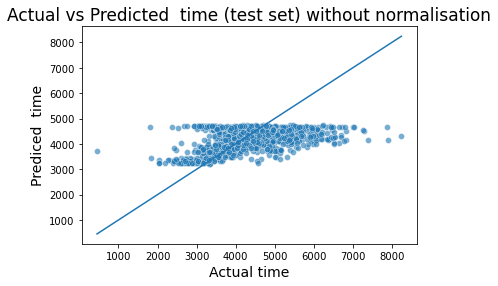

In [19]:
sns.scatterplot(x=y_test, y=SVReg_prediction, alpha=0.6)
sns.lineplot(y_test, y_test)

plt.xlabel('Actual time', fontsize=14)
plt.ylabel('Prediced  time', fontsize=14)
plt.title('Actual vs Predicted  time (test set) without normalisation', fontsize=17)
plt.show()

In [24]:
chunks2 = get_chunks(data_list)

Index at chunk_list 0  is  ../../Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/18_3.csv :  (3896, 19)
Index at chunk_list 1  is  ../../Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/67_6.csv :  (4001, 19)
Index at chunk_list 2  is  ../../Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/142_9.csv :  (252, 17)
Index at chunk_list 3  is  ../../Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/17_16.csv :  (307, 16)
Index at chunk_list 4  is  ../../Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/46A_74.csv :  (11186, 19)
Index at chunk_list 5  is  ../../Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/122_14.csv :  (4164, 19)
Index at chunk_list 6  is  ../../Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/150_8.csv :  (4907, 19)
Index at chunk_list 7  is  ../../Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/33X_49.csv :  (181, 17)
Index at chunk_list 8  is  ../../Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/83_19.csv :  (1051, 16)
Index at chunk_list 9  is  ../../Pelin/Chunks/D

Index at chunk_list 104  is  ../../Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/40D_104.csv :  (1507, 17)
Index at chunk_list 105  is  ../../Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/53_21.csv :  (1310, 19)
Index at chunk_list 106  is  ../../Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/102_9.csv :  (2800, 19)
Index at chunk_list 107  is  ../../Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/38B_40.csv :  (211, 17)
Index at chunk_list 108  is  ../../Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/185_60.csv :  (155, 15)
Index at chunk_list 109  is  ../../Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/26_29.csv :  (1232, 19)
Index at chunk_list 110  is  ../../Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/114_6.csv :  (1387, 18)
Index at chunk_list 111  is  ../../Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/84X_62.csv :  (204, 17)
Index at chunk_list 112  is  ../../Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/7A_86.csv :  (1023, 19)
Index at chunk_list 113  i

Index at chunk_list 188  is  ../../Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/15A_84.csv :  (3887, 19)
Index at chunk_list 189  is  ../../Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/16_20.csv :  (7055, 19)
Index at chunk_list 190  is  ../../Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/31A_25.csv :  (833, 19)
Index at chunk_list 191  is  ../../Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/65_72.csv :  (681, 19)
Index at chunk_list 192  is  ../../Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/33B_58.csv :  (2267, 19)
Index at chunk_list 193  is  ../../Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/41_7.csv :  (4834, 19)
Index at chunk_list 194  is  ../../Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/7A_87.csv :  (2178, 19)
Index at chunk_list 195  is  ../../Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/13_70.csv :  (252, 17)
Index at chunk_list 196  is  ../../Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/39_23.csv :  (204, 19)
Index at chunk_list 197  is  .

Index at chunk_list 269  is  ../../Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/40E_91.csv :  (223, 19)
Index at chunk_list 270  is  ../../Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/13_61.csv :  (2194, 19)
Index at chunk_list 271  is  ../../Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/7A_88.csv :  (1259, 19)
Index at chunk_list 272  is  ../../Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/41C_80.csv :  (361, 17)
Index at chunk_list 273  is  ../../Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/185_55.csv :  (308, 15)
Index at chunk_list 274  is  ../../Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/27A_5.csv :  (3080, 19)
Index at chunk_list 275  is  ../../Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/39X_1.csv :  (168, 17)
Index at chunk_list 276  is  ../../Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/37_14.csv :  (4981, 19)
Index at chunk_list 277  is  ../../Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/56A_31.csv :  (1680, 19)
Index at chunk_list 278  is 

In [36]:
results_df = pd.DataFrame()

mae_all = []
mse_all = []
rmse_all = []
r2_all = []
CV_mae_all = []
CV_rmse_all = []
CV_r2_all = []


SVReg = SVR(C=10)
count = 0
for chunk in chunks2:
    print(f'generating pickel for chunk index {count}')
    getPickle(SVReg, 'SVR', chunk, 'Feature_selection_V1.csv')
    count +=1

generating pickel for chunk index 0
generating pickel for chunk index 1
generating pickel for chunk index 2
generating pickel for chunk index 3
generating pickel for chunk index 4
generating pickel for chunk index 5
generating pickel for chunk index 6
generating pickel for chunk index 7
generating pickel for chunk index 8
generating pickel for chunk index 9
generating pickel for chunk index 10
generating pickel for chunk index 11
generating pickel for chunk index 12
generating pickel for chunk index 13
generating pickel for chunk index 14
generating pickel for chunk index 15
generating pickel for chunk index 16
generating pickel for chunk index 17
generating pickel for chunk index 18
generating pickel for chunk index 19
generating pickel for chunk index 20
generating pickel for chunk index 21
generating pickel for chunk index 22
generating pickel for chunk index 23
generating pickel for chunk index 24
generating pickel for chunk index 25
generating pickel for chunk index 26
generating 

generating pickel for chunk index 220
generating pickel for chunk index 221
generating pickel for chunk index 222
generating pickel for chunk index 223
generating pickel for chunk index 224
generating pickel for chunk index 225
generating pickel for chunk index 226
generating pickel for chunk index 227
generating pickel for chunk index 228
generating pickel for chunk index 229
generating pickel for chunk index 230
generating pickel for chunk index 231
generating pickel for chunk index 232
generating pickel for chunk index 233
generating pickel for chunk index 234
generating pickel for chunk index 235
generating pickel for chunk index 236
generating pickel for chunk index 237
generating pickel for chunk index 238
generating pickel for chunk index 239
generating pickel for chunk index 240
generating pickel for chunk index 241
generating pickel for chunk index 242
generating pickel for chunk index 243
generating pickel for chunk index 244
generating pickel for chunk index 245
generating p

In [38]:
results_df

,MODEL,ROUTEID,MAE,RMSE,R2
0,SVR,18_3,-760.195739,-1043.035582,0.145120
1,SVR,67_6,-629.725569,-845.041906,0.178439
2,SVR,142_9,-208.639922,-413.632987,-0.028409
3,SVR,17_16,-393.564908,-509.548191,0.087816
4,SVR,46A_74,-726.998853,-964.099977,0.097863
...,...,...,...,...,...
300,SVR,17A_14,-502.824529,-883.436798,-0.098462
301,SVR,66A_38,-595.455874,-920.760670,0.035755
302,SVR,15A_85,-645.559605,-894.127905,0.022356
303,SVR,47_136,-673.833139,-1038.667803,0.035434


In [39]:
print("max r2 = ", results_df['R2'].max())
print("mean r2 = ", results_df['R2'].mean())


max r2 =  0.4732567883321579
mean r2 =  0.04345136269168971


# Optimal C & gamma classifier


In [22]:
'''df3 = chunks[4].copy()

y = df3['TOTAL_JOURNEY_TIME']
X = df3.drop('TOTAL_JOURNEY_TIME', axis=1)

y = y.to_numpy()

# filter only correlated features
routeid = df3['ROUTEID'].unique()[0]
source_features = get_sourcefeatures('../LinearRegression/LR_feature_selection.csv', routeid)
X = X[source_features]

X_2d = X.iloc[:, :2] # all rows, only first two columns
X_2d = X_2d[y > 0]
y_2d = y[y > 0]
y_2d -= 1

scaler = StandardScaler()
X = scaler.fit_transform(X)
X_2d = scaler.fit_transform(X_2d)


from sklearn.svm import SVC
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV

C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv)
grid.fit(X, y)

print(
    "The best parameters are %s with a score of %0.2f"
    % (grid.best_params_, grid.best_score_)
)

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
'''

ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.